In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib
import h5py
sys.path.append('/Users/ajc/Core/PyScript')
import readdata

In [2]:
#outfile='/Users/ajc/Core/PostProcessing/barrow_watershed/2021/January/'

In [3]:
#path_cades = "/Users/ajc/FUSE/simulations/production/barrow_watershed"
path = "/Users/ajc/Core/simulations/projections/barrow_watershed"
#path=path_cades
outfile ='/Users/ajc/Core/PostProcessing/barrow_watershed/2021/July/'

In [4]:
colors = ['r','blue','grey','green','darkgreen','k']
marks = ['.','*', '+', 'o']
marks = ['-','-','-','-','-']

SimLabels = ['S%s'%i for i in range(3,0,-1)]

In [5]:
#Set 1 : flow processes
S1 = [os.path.join(path, 'CESM_04/CESM_5050_R1%s_B'%i) for i in range(3)]
S3 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R3%s'%i) for i in range(1)] 
S5 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
Simulations = [S5, S3, S1]
Labels = ['dynamic-microtopography','static-microtopography','no-microtopography']

In [ ]:
# Set 2: ice rich top porosity sensitivity 
S5_P80 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
S5_P70 = [os.path.join(path, 'CESM_05/CESM_I5050_P70_R5%s'%i) for i in range(1)]
S5_P90 = [os.path.join(path, 'CESM_05/CESM_I5050_P90_R5%s'%i) for i in range(1)]
Simulations = [S5_P80, S5_P70, S5_P90]
Labels = ['dynamic-microtopography (por = 80%)','dynamic-microtopography (por = 70%)','dynamic-microtopography (por = 90%)']

In [ ]:
# Set 2: ice rich top porosity sensitivity
S5_D0515 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
S5_D0020 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D0020'%i) for i in range(1)]
S5_D1010 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D1010'%i) for i in range(1)]
S5_D2020 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D2020'%i) for i in range(1)]
Simulations = [S5_D0515, S5_D0020, S5_D1010,S5_D2020]
Labels = ['dynamic-microtopography (d = [5,15])','dynamic-microtopography (d = [0,2])',
          'dynamic-microtopography (d = [10,10])', 'dynamic-microtopography (d = [20,20])']



In [16]:
sim_len = len(Simulations)
sim_len

3

In [7]:
#path_sf ="/Users/ajc/Core/simulations/projections/barrow_watershed_02/CESM_15/CESM_5050_R60_B/visdump_surface_star_data.h5"
#file_surf= h5py.File(path_sf,'r')

#surface_area = np.sum(list(file_surf['surface_star-cell_volume.cell.0']['100095']))
surface_area = 112635.47903126487
print (surface_area)
molar_density = 55500.

112635.47903126487


In [8]:
def read_file(file):
    d = np.loadtxt(file,usecols=1,skiprows=6)
    t1 = np.loadtxt(file,usecols=0,skiprows=6)
    t = np.array([x/86400./365. for x in t1])
    #print (len(d),len(t))
    l = np.minimum(len(d),len(t))
    return d[:l],t[:l]

def read_set(set,var='surface_flux-halfday.dat'):
    dat = []
    tim = []
    for s in set:
        file = os.path.join(path,s, var)
        #print (file)
        d = np.loadtxt(file,usecols=1,skiprows=6)
        t1 = np.loadtxt(file,usecols=0,skiprows=6)
        t = np.array([x/86400./365. for x in t1])
        
        L = len(d)%(365*2)
        if L >0:
            d = d[:-L]
            t = t[:len(d)]
            
        dat.append(d)
        tim.append(t)
    dat = np.concatenate(dat)
    tim = np.concatenate(tim)
    
    return dat, tim


In [9]:
def get_vars_names(simul):
    names = dict()
    #file = os.path.join(Simulations[0][0],'data_collection.dat')
    file = os.path.join(simul,'data_collection.dat')
    with open(file) as fd:
        count = 0
        for f in fd:
            if ('Observation Name' in f):
                f1 = f.split(':')
                #print (f1, f[-1])
                if 'time [d]' in f1[-1]:
                    names['Time'] = count
                    #print (f1, f1[-1],names)
                elif 'outlet discharge [mol d^-1]' in f1[-1]:
                    names['Discharge'] = count 
                elif 'total evaporation [m d^-1]' in f1[-1]:
                    names['ET'] = count
                elif 'snow precipitation [m d^-1]' in f1[-1]:
                    names['Psnow'] = count
                elif 'rain precipitation [m d^-1]' in f1[-1]:
                    names['Prain'] = count
                elif 'subsurface water content [mol]' in f1[-1]:
                    names['SS_wc'] = count
                    #print (count)
                elif 'surface water content [mol]' in f1[-1]:
                    #print (count)
                    names['Sf_wc'] = count
                elif 'snow water content [mol]' in f1[-1]: #but this is in m^3 correction
                    names['Snow_wc'] = count
                elif 'surface air temperature [K]' in f1[-1]:
                    names['Tair'] = count
                elif 'surface carbon decomposition rate [-]' in f1[-1]:
                    names['Sf_CDR'] = count
                elif 'surface moisture content [-]' in f1[-1]:
                    names['Sf_mc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface volumetric wc [-]' in f1[-1]:
                    names['Sf_vol_wc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface column average temperature [K]' in f1[-1]:
                    names['Sf_avg_T'] = count
                elif 'surface ALT average temperature [K]' in f1[-1]:
                    names['Sf_ALT_avg_T'] = count
                elif 'surface saturated_fraction [-]' in f1[-1]:
                    names['Sf_sat_frac'] = count
                elif 'surface thaw depth min [m]' in f1[-1]:
                    names['Sf_TD_min'] = count
                elif 'surface thaw depth max [m]' in f1[-1]:
                    names['Sf_TD_max'] = count
                elif 'surface maximum thaw depth [m]' in f1[-1]:
                    names['Sf_maxTD'] = count
                elif 'surface water table [m]' in f1[-1]:
                    names['Sf_WT'] = count
                elif 'surface subsurface exchange [m]' in f1[-1]:
                    names['Sf_exchangeFlux'] = count
                elif 'surface initial elevation [m]' in f1[-1]:
                    names['Sf_InitElev'] = count
                elif 'surface mean subsidence [m]' in f1[-1]:
                    names['Sf_mean_Subsidence'] = count
                else:
                    #names['Sf_DNE_%s'%count] = count
                    print ('DNE:',count, f[-1])
                count = count + 1
    return names

In [10]:
#file = os.path.join(Simulations[0][0],'data_collection.dat')
#df = pd.read_csv(file, comment='#')
#print (Simulations[0][0], len(names.keys()), len(df.columns))
#df.columns = names.keys()

In [11]:
#forcing = h5py.File("/Users/ajc/FUSE/simulations/production/barrow_watershed/data/CESM/CESM-RCP8_5-2006-2100_snowadjusted_supersmoothDM_2006.h5",'r')
forcing_watershed_FM = h5py.File("/Users/ajc/Core/PreProcessing/ats-intermediate-ngee/data/SNAP/CESM-RCP8.5-2006-2100_dm1985-2015-FM_2006.h5",'r')

478.99578665862356 (array([0]),) (array([18]),)


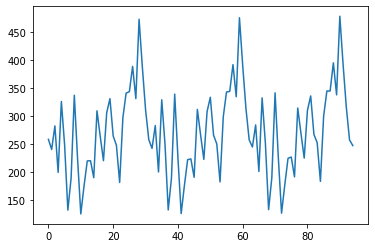

In [99]:
d1 = forcing_watershed_FM['precipitation rain [m s^-1]']
d2 = forcing_watershed_FM['precipitation snow [m SWE s^-1]']
rain_mm = np.reshape(d1,(-1,365)).mean(axis=1)*86400*365*1000
snow_mm = np.reshape(d2,(-1,365)).mean(axis=1)*86400*365*1000
precip_annual = snow_mm + rain_mm
r1 = np.array(d1)*86400*1000
r2 = np.array(d2)*86400*1000
precip_daily = r1 + r2
plt.plot(precip_annual)
s= 10 + 31 + 31
e = s + 22
pmax,pmin = np.max(precip_annual[s:e]), np.min(precip_annual[s:e])
print (np.max(precip_annual[s:e]), np.where(precip_annual[s:e]== pmin), np.where(precip_annual[s:e]== pmax))

In [13]:
def get_moving_average(d, m=5):
    d_avg = []
    len1 = len(d)
    for i in range(len1):
        if i < m:
            s1 = np.mean(d[:i+1])
        else:
            s1= np.mean(d[i-m:i])

        d_avg.append(s1)
    return d_avg

In [14]:
#Read discharge

time = 2006 + np.linspace(0,94,94,dtype='int')
to_day_mm = 86400 * 1000
to_year_mm = 86400 * 365 * 1000
basin_area = 112635.48
to_mm = 1000.

In [15]:

def get_daily_data():
    daily = dict()
    for i,sim in enumerate(Simulations):
        df = pd.DataFrame(columns=[''])
        #df.columns = names.keys()
        
        for s in sim:
            file = os.path.join(s,'data_collection.dat')
            
            df1 = pd.read_csv(file, comment='#')
            names = get_vars_names(s)
            print (file, len(names.keys()))
            df1.columns = names.keys()
            
            rows,cols = df1.shape
            rows = rows - rows%365.
            df1 = df1.truncate(before=0,after=rows-1,axis='index')
            
            df = df.append(df1)
            #print (df)
        daily[SimLabels[i]] = df
        
    return daily

SimData_daily = get_daily_data()

/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_05/CESM_I5050_P80_R50/data_collection.dat 23
/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_05/CESM_I5050_P80_R30/data_collection.dat 21
/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_04/CESM_5050_R10_B/data_collection.dat 16
/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_04/CESM_5050_R11_B/data_collection.dat 16
/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_04/CESM_5050_R12_B/data_collection.dat 16


In [17]:
#print (SimData_daily)
to_year = 365
to_mm = 1000
def get_discharge():
    Q_daily = dict()
    Q_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1/(molar_density*surface_area)
        d = [x* convert for x in SimData_daily[keys[i]]['Discharge'] ]
        Q_daily[keys[i]]= d*to_mm
        #print (d.shape)
        Q_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Q_daily, Q_annual
Q_daily, Q_annual = get_discharge()

def get_Pr():
    Pr_daily = dict()
    Pr_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['Prain'] ]
        Pr_daily[keys[i]]= d*to_mm
        Pr_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Pr_daily, Pr_annual
Pr_daily, Pr_annual = get_Pr()


def get_Ps():
    Ps_daily = dict()
    Ps_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['Psnow'] ]
        Ps_daily[keys[i]]= d*to_mm
        Ps_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Ps_daily, Ps_annual
Ps_daily, Ps_annual = get_Ps()

def get_time():
    T_daily = dict()
    T_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1./(365)
        d = [1985 + x* convert for x in SimData_daily[keys[i]]['Time'] ]
        T_daily[keys[i]]= d
        T_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return T_daily, T_annual
T_daily, T_annual = get_time()

dict_keys(['S3', 'S2', 'S1']) ['S3', 'S2', 'S1']
dict_keys(['S3', 'S2', 'S1']) ['S3', 'S2', 'S1']


In [18]:
def get_ET():
    ET_daily = dict()
    ET_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['ET'] ]
        ET_daily[keys[i]]= d*to_mm
        ET_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return ET_daily, ET_annual
ET_daily, ET_annual = get_ET()

In [19]:
def get_Storage():
    ST_daily = dict()
    ST_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1/(molar_density*surface_area)
        ss_d = [x * convert for x in SimData_daily[keys[i]]['SS_wc'] ] #moles --> m
        sf_d = [x * convert for x in SimData_daily[keys[i]]['Sf_wc'] ] #moles --> m
        snow_d = [x /surface_area for x in SimData_daily[keys[i]]['Snow_wc'] ] #m^3 --> m
        d = [x+y+z for x,y,z in zip(ss_d, sf_d,snow_d)]
        ST_daily[keys[i]]= d*to_mm
        ST_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return ST_daily, ST_annual
ST_daily, ST_annual = get_Storage()

def get_Storage():
    ST_daily = dict()
    ST_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1/(molar_density*surface_area)
        ss_d = [x * convert for x in SimData_daily[keys[i]]['SS_wc'] ] #moles --> m
        sf_d = [x * convert for x in SimData_daily[keys[i]]['Sf_wc'] ] #moles --> m
        snow_d = [x /surface_area for x in SimData_daily[keys[i]]['Snow_wc'] ] #m^3 --> m
        d = [x+y+z for x,y,z in zip(ss_d, sf_d,snow_d)]
        ST_daily[keys[i]]= d*to_mm
        ST_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return ST_daily, ST_annual
ST_daily, ST_annual = get_Storage()

In [20]:
def get_Carbon():
    CDR_daily = dict()
    CDR_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1#/(molar_density*surface_area)
        d = [x * convert for x in SimData_daily[keys[i]]['Sf_CDR'] ] 
        CDR_daily[keys[i]]= d#*to_mm
        CDR_annual[keys[i]]= np.reshape(d,(-1,365)).sum(axis=1)#*to_year #* to_mm
    return CDR_daily, CDR_annual
CDR_daily, CDR_annual = get_Carbon()


In [159]:
cesm_years_o = [2006, 2036, 2067, 2098] 
cesm_years = [x - 2005 for x in cesm_years_o]

print (precip_annual[cesm_years], cesm_years)
print (Q_annual['S1'][:32], len(Q_annual['S1'][:31]),Q_annual['S1'][cesm_years])

[240.96071597 258.43710591 258.16964081 257.90217571] [1, 31, 62, 93]
[122.6235096   81.31856419  90.88298357 179.82921755 106.62234125
 166.11274198 136.5760366  125.62610866 162.47631487 142.90257388
  69.57137152 103.71921747 224.74687741  93.90328649 195.00837685
  54.06174793  67.52118192  19.03170109 182.74316708  91.00053948
 125.20824209 102.28965856  98.25959031  97.00759404 136.58325338
 201.27745551 190.80816147 147.92908303 114.03873233 145.37004302
 105.90282222  70.6622702 ] 31 [81.31856419 70.6622702  75.09495497 79.92254164]


# Discharge

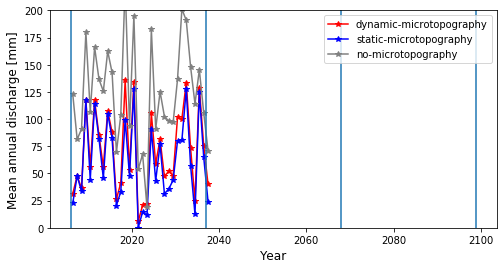

In [153]:
bars = False #True
fig = plt.figure(figsize=(8,4))
x = np.arange(0,4,1)
Colors = ['r', 'g', 'b','grey']

if not bars:
    for i in range(sim_len):
        s = SimLabels[i]
        #d = get_moving_average(Q_annual[s],m=1)
        d = Q_annual[s]
        plt.plot(T_annual[s][:32],d[:32],label=Labels[i],color=colors[i],marker='*')
        plt.legend()
        plt.ylabel('Mean annual discharge [mm]',fontsize=12, fontweight='normal')
        plt.xlabel('Year',fontsize=12, fontweight='normal')
        plt.ylim(0,200)
        #plt.xlim(2005.5,2099.5)
    for y in cesm_years_o:
        plt.axvline(x=y)
        
        plt.savefig(outfile+'/Projected-Q_linesA.pdf', bbox_inches='tight', dpi=500)
        #plt.savefig(outfile+'/Projected-Q_por_sensivity_por.pdf', bbox_inches='tight', dpi=500)
else:
    dat = []
    for i in [2,0,1]:
        s = SimLabels[i]
        d = []
        
        for k1,k in enumerate(cesm_years):
            print (s, k, Q_annual[s][k], len(Q_annual[s]))
            d.append(Q_annual[s][k])
        print (d,cesm_years)
        print ('--------_')
        #d = [c/Q_annual[SimLabels[2]][0] for c in d]
        dat.append(d)
        plt.bar(x, height=d, width=0.2,color=Colors[i],alpha=1,label=Labels[i])
   
    #d1 = [dat[0][k4] - dat[1][k4] for k4 in range(4)]
    #plt.bar(x+0.21, height=d1, width=0.2,color=Colors[3],alpha=1)#,label=Labels[i])
    plt.legend()
    plt.ylabel('Mean annual discharge [mm]',fontsize=12, fontweight='normal')
    plt.xlabel('Year',fontsize=12, fontweight='normal')
    plt.xticks(x, cesm_years_o)
    #plt.savefig(outfile+'/Projected-Q_lines.pdf', bbox_inches='tight', dpi=500)




In [ ]:
fig = plt.figure(figsize=(8,4))
for i,s in enumerate(SimLabels):
    d = get_moving_average(ET_annual[s])
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
plt.legend()
plt.ylabel('Annual average ET [mm]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
plt.ylim(100,400)
plt.xlim(2006.5,2099.5)
#plt.savefig(outfile+'/Projected-ET.pdf', bbox_inches='tight', dpi=500)
plt.savefig(outfile+'/Projected-ET_sensivity_por.pdf', bbox_inches='tight', dpi=500)

In [ ]:
fig = plt.figure(figsize=(8,4))
for i,s in enumerate(SimLabels):
    #d = [ (x - ST_annual[s][0])/ST_annual[s][0]*100 for x in ST_annual[s]]
    #d = get_moving_average(d)
    d = get_moving_average(ST_annual[s])
    d = [ (x - d[0])/d[0]*100 for x in d]
    #d = [ x/d[0] for x in d]
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
plt.legend()
plt.ylabel('Storage (% change) [-]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
plt.ylim(-2.0,0.4)
plt.xlim(2006.5,2099.5)
#plt.savefig(outfile+'/Projected-storage.pdf', bbox_inches='tight', dpi=500)
plt.savefig(outfile+'/Projected-storage_sensivity_por.pdf', bbox_inches='tight', dpi=500)

In [ ]:
fig = plt.figure(figsize=(8,4))
for i,s in enumerate(SimLabels):
    d = get_moving_average(CDR_annual[s])
    d = d/d[0]
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
plt.legend()
plt.ylabel('Carbon decomposition rate [-]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
plt.ylim(0,5)
plt.xlim(2006.5,2099.5)
plt.savefig(outfile+'/Projected-CDR_sensivity_por.pdf', bbox_inches='tight', dpi=500)
# the key point what processes are important for water budget components, 
# sensitivity study of subsidence, models with more or less uniform subsidence across the watershed has no effect
# on hydrology, however, hetereogeneous subsidence has effect on runoff/ET ---> investigate?
# storage decreases in simulations with subsidence
# lets focus on the processes details instead of conclusions about the future.


In [ ]:
def plot_Q():
    %matplotlib qt
    fig, axs = plt.subplots(1,1, figsize=(6,4), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)

    plt.tight_layout()
    #axs = axs.ravel()
    Colors = ['k','b','grey','g','r','m']
 
    axs.fill_between(1985 + Q['S6_time'], Q['S6_data']-0, Q['S6_data']*0+Q['S1_data'] , color='lightgray')
    axs.fill_between(1985 + Q['S6_time'], Q['S3_data'], Q['S6_data']+0 , color='gray')
    
    axs.plot(1985 + Q['S6_time'],Q['S6_data'],color=Colors[i],label=Labels[i],linestyle='dashed')
    axs.set_xlabel('Calendar year',fontsize=12, fontweight='normal')
    axs.set_ylabel('Annual average discharge [mm]',fontsize=12, fontweight='normal')
    axs.legend(loc='upper right',fontsize=8)
    #axs.set_xlim(2005,2100)
    #axs.plot(time,precip_annual[:-1],'g')


    #axs.plot(t1[tt0*365:(tt0+1)*365]-21,precip_daily[tt0*365:(tt0+1)*365],'g')
    #plt.plot(rain_mm,'k')
    #plt.plot(snow_mm,'m')
    #plt.plot(precip_annual,'r')
    #print (outfile)
    #plt.savefig(outfile+'discharge-annualavg_bars.pdf', bbox_inches='tight', dpi=500)
    #print (outfile+'discharge-annualavg_bars.pdf')

In [ ]:
#plot_Q()

In [ ]:
Including run-on in our simulations improve our understanding of total carbon budget. the evaporation will be under estimated
if we ignore run-on
long-term trend
inter-annual dynamics
seasonal vairations/dynamics
fire consumes carbon, which decrease DOC in stream

In [ ]:
# 1) negligible differences in the discharge
# 2) significant differences in the evaporation, this implies base-case should stay relatively wetter,
#.   this will impact carbon decomposition rate
# 3) high NO3 and low N03, high DOC 

In [9]:
(135000 - 106200)/106000*100

27.169811320754718

In [15]:
#8833*.15
salary_ornl = 106200
x1 = 8833*.274
x = 8833 + x1
s6_401k_ornl = salary_ornl*6/100 +  salary_ornl*6/100 * 0.5
print (x1, x, x*12, s6_401k_ornl)

2420.242 11253.242 135038.904 9558.0


In [42]:
salary_orig = 135000. # 10% increase
#la_tax = salary_orig*4/100
la_tax = (1000 * 2/100 + 5000 * 4/100 + (salary_orig/12-6000)*5/100)*12

salary = salary_orig - la_tax
s6_401k = salary_orig * 6/100 + (salary_orig * 6/100)*0.38
medical = -615 + 150

net = medical + (s6_401k - s6_401k_ornl )/12 + (salary - salary_ornl)/12
print (net, (s6_401k - s6_401k_ornl)/12., (salary - salary_ornl)/12, la_tax)

1587.5 135.0 1917.5 5790.0


In [38]:
#print (salary_orig/12., 125000/12.)

11628.333333333334 10416.666666666666


In [35]:

print (la_tax, la_tax*12, la_tax4)

482.5 5790.0 5400.0


In [ ]:
2 meadian life time , 2.6hr give mean of 1hr median
alpha = 2.5 1/sec